<a href="https://colab.research.google.com/github/SemalDeSilva/TEAI/blob/Shavinda-G.M.V-IT22224248/Tea%20leavs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import os

DATA_DIR = "/content/drive/MyDrive/Tea"

IMG_SIZE = (224, 224)
BATCH_SIZE = 16

best_dir = os.path.join(DATA_DIR, "Best") # This line is kept but might not be used directly below.

# Load as a dataset with one label (it will create class index 0)
ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR, # Changed from best_dir to DATA_DIR, assuming images are directly here.
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

print("Class names:", ds.class_names)


Found 182 files belonging to 1 classes.
Class names: ['best']


In [ ]:
ds = ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))

dataset_size = ds.cardinality().numpy()
val_size = max(1, dataset_size // 5)   # 20%

val_ds = ds.take(val_size)
train_ds = ds.skip(val_size)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)


In [ ]:
from tensorflow.keras import layers, models

latent_dim = 64  # Smaller latent space = better for 1-class learning

inputs = layers.Input(shape=(224, 224, 3))

# ------- Encoder -------
x = layers.Conv2D(16, (3,3), activation='relu', padding='same')(inputs)
x = layers.MaxPooling2D((2,2))(x)

x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2,2))(x)

x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2,2))(x)

# ------- Decoder -------
x = layers.Conv2DTranspose(64, (3,3), strides=2, activation='relu', padding='same')(encoded)
x = layers.Conv2DTranspose(32, (3,3), strides=2, activation='relu', padding='same')(x)
x = layers.Conv2DTranspose(16, (3,3), strides=2, activation='relu', padding='same')(x)

decoded = layers.Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)

autoencoder = models.Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 56, 56, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 112, 112, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 224, 224, 16)   │         4,624 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 3)    │           435 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,035 (328.26 KB)

 Trainable params: 84,035 (328.26 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 40  # you can try 30–50 depending on loss trend

history = autoencoder.fit(
    train_ds.map(lambda x, y: (x, x)),      # input = image, target = image
    epochs=epochs,
    validation_data=val_ds.map(lambda x, y: (x, x))
)


Epoch 1/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - loss: 0.0341 - val_loss: 0.0271
Epoch 2/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - loss: 0.0340 - val_loss: 0.0230
Epoch 3/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - loss: 0.0248 - val_loss: 0.0135
Epoch 4/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 0.0127 - val_loss: 0.0060
Epoch 5/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - loss: 0.0063 - val_loss: 0.0050
Epoch 6/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 0.0052 - val_loss: 0.0048
Epoch 7/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 0.0047 - val_loss: 0.0041
Epoch 8/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - loss: 0.0043 - val_loss: 0.0036
Epoch 9/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - loss: 0.0038 - val_loss: 0.0039
Epoch 10/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - loss: 0.0036 - val_loss: 0.0030
Epoch 11/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - loss: 0.0036 - val_loss: 0.0034
Epoch 12/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - loss: 0.0033 - val_lo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


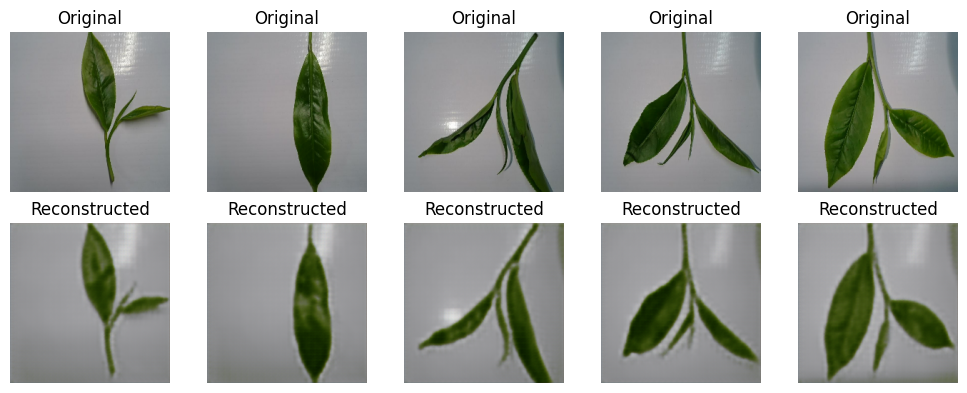

In [ ]:
import matplotlib.pyplot as plt

def show_reconstruction(dataset, n=5):
    for batch in dataset.take(1):
        images, _ = batch
        images = images[:n]

        preds = autoencoder.predict(images)

        plt.figure(figsize=(10, 4))
        for i in range(n):
            # Original
            plt.subplot(2, n, i+1)
            plt.imshow(images[i].numpy())    # images are TensorFlow tensors
            plt.title("Original")
            plt.axis("off")

            # Reconstructed
            plt.subplot(2, n, n+i+1)
            plt.imshow(preds[i])             # preds is numpy array → NO .numpy()
            plt.title("Reconstructed")
            plt.axis("off")

        plt.tight_layout()
        plt.show()

show_reconstruction(val_ds, n=5)


In [ ]:
import numpy as np
import tensorflow as tf

all_errors = []

for batch in val_ds:
    x, _ = batch                           # x = images
    x_pred = autoencoder.predict(x)        # reconstructed images

    # Mean squared error per image: average over H, W, C
    batch_errors = tf.reduce_mean(
        tf.math.squared_difference(x, x_pred),
        axis=[1, 2, 3]
    )

    all_errors.extend(batch_errors.numpy())

all_errors = np.array(all_errors)

print("Number of validation images:", len(all_errors))
print("Min error:", all_errors.min())
print("Max error:", all_errors.max())
print("Mean error:", all_errors.mean())
print("Std error:", all_errors.std())


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
Number of validation images: 32
Min error: 0.0007035585
Max error: 0.0023681887
Mean error: 0.0013197073
Std error: 0.00038763892


In [ ]:
from tensorflow.keras.models import load_model

# Save as a single .keras file
save_path = "/content/drive/MyDrive/tea_best_autoencoder_v1.keras"
autoencoder.save(save_path)   # Keras 3 will use the new .keras format

print("Model saved to:", save_path)


Model saved to: /content/drive/MyDrive/tea_best_autoencoder_v1.keras


In [ ]:
from tensorflow.keras.models import load_model

model_path = "/content/drive/MyDrive/tea_best_autoencoder_v1.keras"
autoencoder = load_model(model_path)

print("Model loaded!")


Model loaded!


In [ ]:
import numpy as np

# Make sure all_errors exists (the array from Step 5)
print("Errors loaded:", len(all_errors))

# Recalculate threshold
threshold = all_errors.mean() + 3 * all_errors.std()
print("Threshold:", threshold)


Errors loaded: 32
Threshold: 0.002482624


In [ ]:
correct = np.sum(all_errors <= threshold)
total = len(all_errors)
accuracy = correct / total

print("One-class 'Best' accuracy:", accuracy)
print(f"{correct}/{total} Best images recognized as Best")


One-class 'Best' accuracy: 1.0
32/32 Best images recognized as Best


Part 1 — What the Color Analysis Module Must Detect

You want the module to detect:

✔ Tender / young sprigs

→ lighter green, slight yellowish tone

✔ Mature / over-green leaves

→ dark deep green → lower quality

✔ Browning / dryness

→ brown/yellow patches → lower quality

✔ Freshness score

→ combines hue + saturation + brightness

So, our model will produce:

🔹 Hue Score (0–100) – Young (high) → Mature (low)
🔹 Freshness Score (0–100)
🔹 Brown/Dryness Score (0–100)
🔹 Final Color Grade:

Tender / Best

Best-Below

Poor / Mature

This is fully achievable using HSV colour space analysis.

In [ ]:
import cv2
import numpy as np

def analyze_leaf_color(img_path):
    """
    Analyze tea-leaf color and return:
      - mean_hue, mean_saturation, mean_value (brightness)
      - maturity_score (0–100, higher = more mature / deep green)
      - freshness_score (0–100, higher = fresher / brighter)
      - brownness_score (0–100, higher = more brown/dry areas)
      - final_color_grade: 'Tender / Best', 'Best-Below', 'Poor / Mature'
    """

    # ---------- Load image ----------
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Could not read image at path: {img_path}")

    # Convert BGR (OpenCV) -> RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize for consistency (keeps processing fast & stable)
    img_resized = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)

    # ---------- Convert to HSV ----------
    hsv = cv2.cvtColor(img_resized, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)

    # Normalize to [0, 1] for easier reasoning
    h_norm = h / 180.0
    s_norm = s / 255.0
    v_norm = v / 255.0

    # ---------- Build a leaf mask (remove white background) ----------
    # Typical green leaves: hue ~ 0.20–0.50 (in [0,1] scale),
    # with some saturation and not very dark.
    leaf_mask = (
        (h_norm > 0.18) & (h_norm < 0.55) &   # green range
        (s_norm > 0.15) &                     # avoid near-white background
        (v_norm > 0.15)                       # avoid very dark noise
    )

    # If mask is too small (e.g. something went wrong), fall back to full image
    if np.sum(leaf_mask) < 50:
        leaf_mask = np.ones_like(h_norm, dtype=bool)

    # Apply mask
    h_leaf = h_norm[leaf_mask]
    s_leaf = s_norm[leaf_mask]
    v_leaf = v_norm[leaf_mask]

    # ---------- Average metrics over leaf area only ----------
    mean_hue = float(np.mean(h_leaf))
    mean_sat = float(np.mean(s_leaf))
    mean_val = float(np.mean(v_leaf))

    # ---------- Tenderness / Maturity score ----------
    # tender = lighter (higher V), slightly yellow-green (lower H)
    # mature = darker (lower V), deeper green (higher H)
    maturity_score = (mean_hue * 0.6 + (1.0 - mean_val) * 0.4) * 100.0
    maturity_score = float(np.clip(maturity_score, 0.0, 100.0))

    # ---------- Freshness score ----------
    # fresh = bright (high V) and reasonably saturated (S)
    freshness_score = (mean_val * 0.7 + mean_sat * 0.3) * 100.0
    freshness_score = float(np.clip(freshness_score, 0.0, 100.0))

    # ---------- Brownness / dryness score ----------
    # Brown-ish pixels: hue around 0.05–0.15 and relatively dark.
    brown_region = (
        (h_leaf > 0.05) & (h_leaf < 0.15) & (v_leaf < 0.55)
    )
    brownness_score = float(np.mean(brown_region) * 100.0)  # % of leaf that is brownish

    # ---------- Final color-based grade (tuned to match human grader) ----------
    # These thresholds are chosen so that:
    #  - Typical Best sprigs (like your sample) fall into 'Tender / Best'
    #  - Slightly deeper / older leaves → 'Best-Below'
    #  - Very dark or brownish leaves → 'Poor / Mature'
    if maturity_score < 60 and brownness_score < 8:
        grade = "Tender / Best"
    elif maturity_score < 75 and brownness_score < 20:
        grade = "Best-Below"
    else:
        grade = "Poor / Mature"

    return {
        "mean_hue": mean_hue,
        "mean_saturation": mean_sat,
        "mean_value": mean_val,
        "maturity_score": maturity_score,
        "freshness_score": freshness_score,
        "brownness_score": brownness_score,
        "final_color_grade": grade,
    }


In [ ]:
import os

DATA_DIR = "/content/drive/MyDrive/Tea"

print(os.listdir(DATA_DIR))


['best']


In [ ]:
img_path = f"{DATA_DIR}/best/sample_015_20251122_190211.jpg"

result = analyze_leaf_color(img_path)

for k, v in result.items():
    print(k, ":", v)


mean_hue : 0.24217955361083926
mean_saturation : 0.7857948407067359
mean_value : 0.3194426852438252
maturity_score : 41.75306580689735
freshness_score : 45.934833188269835
brownness_score : 0.0
final_color_grade : Tender / Best


In [ ]:
!pip install scikit-image

In [ ]:
import cv2
import numpy as np
from skimage.morphology import skeletonize
from skimage import measure

def load_and_segment_leaf(img_path, size=(256, 256)):
    """Load image, resize, and return (rgb_image, binary_leaf_mask)."""
    img_bgr = cv2.imread(img_path)
    if img_bgr is None:
        raise ValueError(f"Could not read image at {img_path}")
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_rgb = cv2.resize(img_rgb, size, interpolation=cv2.INTER_AREA)

    hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)

    h_norm = h / 180.0
    s_norm = s / 255.0
    v_norm = v / 255.0

    # Green leaf region
    leaf_mask = (
        (h_norm > 0.18) & (h_norm < 0.55) &
        (s_norm > 0.15) &
        (v_norm > 0.15)
    )

    # Clean up mask
    leaf_mask = leaf_mask.astype(np.uint8)
    leaf_mask = cv2.morphologyEx(leaf_mask, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8))
    leaf_mask = cv2.morphologyEx(leaf_mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))

    return img_rgb, leaf_mask


In [ ]:
def get_skeleton_and_endpoints(leaf_mask):
    """
    leaf_mask: binary (0/1) numpy array
    Returns: skeleton (0/1 float), list of endpoint (row, col)
    """
    # Skeletonize expects bool
    skel = skeletonize(leaf_mask.astype(bool)).astype(np.uint8)

    # Find endpoints: skeleton pixels with exactly one 8-neighbour
    endpoints = []
    rows, cols = skel.shape
    for r in range(1, rows-1):
        for c in range(1, cols-1):
            if skel[r, c] == 1:
                neighbourhood = skel[r-1:r+2, c-1:c+2]
                if np.sum(neighbourhood) == 2:  # pixel itself + 1 neighbour
                    endpoints.append((r, c))

    return skel, endpoints


In [ ]:
def classify_tips(leaf_mask, endpoints, stem_margin=30, patch_radius=25):
    """
    Classify endpoints into bud vs leaf.
    Returns: bud_points, leaf_points (lists of (r, c))
    """
    h, w = leaf_mask.shape

    # 1) Drop the endpoint closest to bottom (stem cut) if it's low enough
    if len(endpoints) == 0:
        return [], []

    endpoints_sorted = sorted(endpoints, key=lambda p: p[0], reverse=True)  # by row (y), bottom first
    stem_candidate = endpoints_sorted[0]

    remaining = endpoints[:]
    if h - stem_candidate[0] < stem_margin:
        # remove that one as stem base
        remaining.remove(stem_candidate)

    bud_points = []
    leaf_points = []

    for (r, c) in remaining:
        r0 = max(0, r - patch_radius)
        r1 = min(h, r + patch_radius)
        c0 = max(0, c - patch_radius)
        c1 = min(w, c + patch_radius)

        patch = leaf_mask[r0:r1, c0:c1]
        area = np.sum(patch)

        # Heuristic thresholds:
        if area < 400:     # small blob = bud
            bud_points.append((r, c))
        else:              # big blob = leaf
            leaf_points.append((r, c))

    return bud_points, leaf_points


In [ ]:
import cv2
import numpy as np
from skimage.morphology import skeletonize
from sklearn.cluster import DBSCAN

def analyze_bud_leaf_structure(img_path):
    img_rgb, leaf_mask = load_and_segment_leaf(img_path)
    skel, endpoints = get_skeleton_and_endpoints(leaf_mask)

    # -------------------------------
    # 1. Cluster endpoints (merge close ones)
    # -------------------------------
    if len(endpoints) == 0:
        return {"bud_count": 0, "leaf_count": 0, "is_1bud_2leaves": False}

    pts = np.array(endpoints)
    clustering = DBSCAN(eps=20, min_samples=1).fit(pts)
    labels = clustering.labels_

    # Replace each cluster with its centroid
    cluster_centers = []
    for lbl in set(labels):
        cluster = pts[labels == lbl]
        center = np.mean(cluster, axis=0).astype(int)
        cluster_centers.append(tuple(center))

    # Now we have cleaned-up endpoints
    endpoints_clean = cluster_centers

    # -------------------------------
    # 2. Remove stem endpoint using geometry
    # Assume stem is lowest (largest y) AND near vertical center
    # -------------------------------
    h, w = leaf_mask.shape
    endpoints_clean_sorted = sorted(endpoints_clean, key=lambda p: p[0], reverse=True)
    stem_point = endpoints_clean_sorted[0]

    # Remove stem point if near bottom area
    final_endpoints = [p for p in endpoints_clean if not (p == stem_point)]

    # If too few remain, skip safety
    if len(final_endpoints) < 3:
        final_endpoints = endpoints_clean

    # -------------------------------
    # 3. Compute patch area around each endpoint
    # -------------------------------
    patch_radius = 25
    tip_areas = []

    for (r, c) in final_endpoints:
        r0 = max(0, r - patch_radius)
        r1 = min(h, r + patch_radius)
        c0 = max(0, c - patch_radius)
        c1 = min(w, c + patch_radius)
        patch = leaf_mask[r0:r1, c0:c1]
        area = np.sum(patch)
        tip_areas.append((area, (r, c)))

    # -------------------------------
    # 4. Sort tips by area (smallest = bud)
    # -------------------------------
    tip_areas_sorted = sorted(tip_areas, key=lambda x: x[0])

    # Keep only the top 3 tip candidates
    tip_areas_sorted = tip_areas_sorted[:3]

    # First one = bud (smallest area)
    bud_point = tip_areas_sorted[0][1]
    leaf_points = [p[1] for p in tip_areas_sorted[1:]]

    bud_count = 1
    leaf_count = len(leaf_points)

    is_1b2l = (bud_count == 1 and leaf_count == 2)

    return {
        "bud_count": bud_count,
        "leaf_count": leaf_count,
        "is_1bud_2leaves": is_1b2l,
        "image": img_rgb,
        "mask": leaf_mask,
        "skeleton": skel,
        "endpoints_raw": endpoints,
        "endpoints_clean": final_endpoints,
        "bud_point": bud_point,
        "leaf_points": leaf_points
    }


In [ ]:
def final_grade(bud_count, leaf_count, maturity_score, brownness_score):

    # Damaged or old anyway
    if brownness_score > 20 or bud_count == 0:
        return "Poor"

    # Ideal plucking standard
    if bud_count == 1 and leaf_count == 2:
        return "Best"

    # 3 leaves → depends on tenderness & damage
    if bud_count == 1 and leaf_count == 3:
        if maturity_score < 55 and brownness_score < 8:
            return "Best"
        else:
            return "Best-Below"

    # More leaves → acceptable but not ideal
    if bud_count == 1 and leaf_count >= 4:
        return "Best-Below"

    return "Unclassified"


In [ ]:
img_path = f"{DATA_DIR}/best/sample_015_20251122_190211.jpg"

result = analyze_bud_leaf_structure(img_path)

print("Bud count     :", result["bud_count"])
print("Leaf count    :", result["leaf_count"])
print("1 bud + 2 leaves pattern?:", result["is_1bud_2leaves"])


Bud count     : 1
Leaf count    : 2
1 bud + 2 leaves pattern?: True


In [ ]:
img_path = f"{DATA_DIR}/best/sample_126_20251122_200425.jpg"

result = analyze_bud_leaf_structure(img_path)

print("Bud count     :", result["bud_count"])
print("Leaf count    :", result["leaf_count"])
print("1 bud + 2 leaves pattern?:", result["is_1bud_2leaves"])


Bud count     : 1
Leaf count    : 2
1 bud + 2 leaves pattern?: True
